## AiDA Lab Tutorial Part 7a--Transfer Learning  Preprocessing (Special Thanks to Dr. Kyle Hasenstab)

By now, you should have trained a simple CNN to accomplish the super-resolution task with either a 955 (part 5) or UNet (part 6).  As you have seen, while results are good, it can take a long time to train these models depending on the complexity of the task.  What if instead, you can for example, take a CNN trained to identify soccer balls in an image, and "transfer" its knowledge to a new task to identify basketballs in an image?  This is the core of the concept of transfer learning.  Transfer learning essentially entails training a model to perform one task, saving the model parameters and weights, then loading those saved weights as an initial starting point when training either the same or modified CNN for a different task!  https://www.tensorflow.org/tutorials/images/transfer_learning is a good reference

Here, we will use the model developed by Dr. Kang Wang, one of the stellar T32 Residents who worked for Albert in around 2018.  His paper is located here and in the repo (Kang_Radiology_AI_Paper): https://pubs.rsna.org/doi/full/10.1148/ryai.2019180022

As you are now acquianted with coding in python, I will preface the CNN training with pseudo-code you will need done in pre-training, as this will differ based on your specific task:

### Preprocessing Pseudo-Code

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from scipy import ndimage
import traceback
import seaborn as sns
%matplotlib notebook

In [2]:
IMAGES = 'CXR_sameday_images_FIXED_16July2020.hdf5'
LABELS = 'combined-images_XR-marked.hdf5'
OUTPUT = 'PreProcessed_Marked_images.hdf5' #changed from 'PreProcessed_Marked_images4.hdf5'
# Removes old preprocessed hdf5, can comment out as necessary
try:
    os.remove(OUTPUT)
except:
    pass
imgs = h5py.File(IMAGES,'r')
labels = h5py.File(LABELS,'r')
outh5 = h5py.File(OUTPUT,'a')
# Brian's model uses 256 x 256 inputs so we track this here:
DIMS = 256

In [3]:
# Assumes your data comes from Fast-Mask, in which case we need to isolate only the image data (exclude metadata)
# and ignore non annotated series

# First need to derive number of non-zero entries (useful ones)
N_list = []
for k in labels.keys():
    # Ignore metadata, only match to img data
    if k[-3:] != '_LR':
        try:
            l = np.array(labels[k][:,:,0,0])
            if np.amax(l) > 0:
                N_list.append(k)
        except:
            pass

In [4]:
count = 0
for key in N_list:
    count += 1
    print(key)
print(count) #301 images annotated with non-zero entries

Abankan_ser_1001_im_1000
Adakas_ser_1_im_0
Adscagik_ser_1_im_0
Afankok_ser_1_im_2
Afineg_ser_9438_im_0
Agenur_ser_1_im_0
Akakil_ser_1_im_0
Akenoy_ser_1570_im_0
Akiskjib_ser_4_im_0
Akongas_ser_1_im_3
Amoyon_ser_1_im_0
Aresit_ser_4235_im_0
Arnadun_ser_7700_im_0
Arnofun_ser_1_im_0
Arnofun_ser_2_im_0
Asitaf_ser_1_im_0
Asodem_ser_6526_im_1
Athomak_ser_1_im_0
Atutey_ser_1_im_0
Atutey_ser_2_im_0
Ayumad_ser_1_im_0
Babinep_ser_1001_im_1000
Badicee_ser_10001_im_0
Bamimmed_ser_1_im_0
Bamoju_ser_1_im_0
Bebimi_ser_8916_im_0
Bedepu_ser_1_im_0
Beefeeprie_ser_1_im_0
Beelolop_ser_1_im_0
Beeplocro_ser_2_im_1
Bekelu_ser_5958_im_0
Bekudur_ser_1_im_0
Belntanath_ser_1_im_0
Belntanath_ser_3_im_0
Bembemug_ser_5974_im_0
Bemukouf_ser_2822_im_0
Beniswo_ser_1_im_0
Bepolien_ser_1_im_0
Bereco_ser_1_im_0
Besolu_ser_1_im_0
Betoxut_ser_1_im_0
Bibipof_ser_1_im_0
Bibogaf_ser_4012_im_0
Bibola_ser_1_im_0
Bifumou_ser_2_im_0
Bihigo_ser_7300_im_1
Bihuqua_ser_1_im_0
Biperap_ser_1_im_0
Bithoodo_ser_5143_im_0
Bladalo_ser_1_im_0

In the above section, you tracked which series to use for the training task.  However, you may also wish to create a dictionary to track how many slices each dataset contains, as you will need this when initializing your hdf5 files next.  In this example, we assume every series has 20 slices (cardiac data) but clearly data is almost never this regular.  You will need to find a smart way to track how many slices will be in the training, validation, and testing bins...

To help our CNN converge, we will make use of augmentation to increase the diversity of training data (only!) the CNN sees.  Specifically, we will rotate images in 5 degree increments from -10 to 10 degrees as well as flip them left-right.

In [ ]:
# Flips and Rotations:
#N_rot = 5 # Rotation augmentation
#N_flip = 2 # Flipping augmentation

In [5]:
# breaking into testing (70% data), validation (20% data), and training sets (10%) numbers
N_tot = len(N_list)
N_training = int(N_tot * 0.7) #0.7 * 301 = 210
N_validation = int(N_tot * 0.2) #0.2 * 301 = 60
N_testing = N_tot - N_training - N_validation #301 - 270 = 31

In [6]:
#reverse order since Albert Hsiao, MD, PhD's annotations are used for training (Ground truth)
N_list.reverse() 
for key in N_list:
    print(key)
# set variables by pulling training, validation, and testing data from randomized list
trainlist = N_list[0:N_training] 
validationlist = N_list[N_training:N_training+N_validation]
testinglist = N_list[N_training+N_validation:]

# do not rotate or flip on the first model
try:
    outh5.create_dataset("training_images", (N_training #* N_rot * N_flip
                                             , DIMS, DIMS, 1), dtype=np.float32)
    outh5.create_dataset("validation_images", (N_validation, DIMS, DIMS, 1), dtype=np.float32)
    outh5.create_dataset("testing_images", (N_testing, DIMS, DIMS, 1), dtype=np.float32)
    
    # dimension[4] has 6 values for 6 channels
    outh5.create_dataset("training_labels", (N_training #* N_rot * N_flip
                                             , DIMS, DIMS, 6), dtype=np.float32)
    outh5.create_dataset("validation_labels", (N_validation, DIMS, DIMS, 6), dtype=np.float32)
    outh5.create_dataset("testing_labels", (N_testing, DIMS, DIMS, 6), dtype=np.float32)
except:
    traceback.print_exc()  

Wuhede_ser_1_im_0
Wonupet_ser_1_im_0
Wedutey_ser_7412_im_0
Warupo_ser_4851_im_1
Warilu_ser_8558_im_0
Waquipue_ser_2_im_0
Wakoocie_ser_2_im_0
Vutomal_ser_1001_im_1000
Vucusa_ser_1_im_0
Virasoos_ser_2_im_0
Virasoos_ser_1_im_0
Utueksod_ser_4343_im_0
Usmafren_ser_1001_im_1000
Urolod_ser_1_im_0
Urncasap_ser_1_im_0
Urenguech_ser_7019_im_0
Upoodtar_ser_1_im_0
Upkubay_ser_10001_im_0
Unufes_ser_1_im_0
Unstayef_ser_1_im_0
Unseedem_ser_1_im_0
Unmupok_ser_2_im_0
Unmupok_ser_1_im_0
Unenus_ser_2_im_0
Unegit_ser_7448_im_0
Unefeg_ser_3960_im_0
Unboeyuf_ser_1_im_0
Umlegob_ser_1_im_0
Ulozak_ser_2_im_0
Uloomok_ser_8962_im_0
Ulafed_ser_6623_im_0
Ukuednif_ser_1_im_0
Ukpuelif_ser_10002_im_0
Ukifer_ser_2_im_0
Ukgosid_ser_1_im_0
Ugopen_ser_5494_im_0
Ufaggep_ser_3_im_0
Uckathuf_ser_1_im_0
Uboyug_ser_1_im_2
Ubimosh_ser_1_im_0
Tuquegi_ser_1_im_0
Tunikax_ser_1_im_0
Tululush_ser_1_im_2
Tukase_ser_1_im_0
Tuhameze_ser_3_im_0
Tuhameze_ser_1_im_0
Tugupay_ser_1_im_0
Tugiquo_ser_2_im_0
Tufescaf_ser_3_im_0
Tufescaf_ser_1

Next, let's handle the training data as you need to shuffle its order.  Note that you will likely need to write a pair of functions (prep_im and prep_lbl here) to do whatever preprocessing may be necessary for your data, e.g. resizing, setting dynamic range to [0,1], etc...

In [7]:
# Hand training data first as it's different due to shuffling
countlist = np.arange(0, N_training #*N_rot*N_flip
                     ) # list of indexes with range from 0 - N_training
print(N_training #*N_rot*N_flip
     )
np.random.shuffle(countlist) #randomize training data
print(countlist)

210
[ 83  49  14 134 197  25 187  20  60 177  95 189  22  45 109 181 124  37
 121 129 194 208  66 130 117 119  11 184 145 147  51  94   1   7  91 102
 173 113 165  71 139 115 151 144 159  35  67 150  26 167  55  96 179  48
 175  19 149 202 135 200  68  78   4 131  70 164   8 206   6  97 125  92
  31 172  72  56  62  36 182  99 190 142  84 162 103 183 136 205 198  28
 178 170  86   2  12 100  33  17 132 123  64 161 101 105  89 146  57 171
 160  77 174  81 191  47 137  63 110  54 199  10 108 126  44  76 112  69
  74  61 188  93 186 152 140  85 163  52  80  90  21  65  18 104 116 154
  53  30 196 185 138 106   0 203   9 128 180 107  39   5 166  13 133 148
  50  38 111  43 176 192  82 141  73 155  79 195 120  58 114 169 204 209
  87 122  88 156 168 193  24  98 127 143  46  27  40  41 201 118  34 158
  15  23 153  42   3  59  29  75  32 207  16 157]


In [8]:
# TRAINING SET:
counter = 0
for k in trainlist:
    #tempimgs = []
    #templabels = []
    
    # create and turn images and lables into float32... we are not saving any _manual or _LR metadata
    inim = np.array(imgs[k]).astype('float32')
    inl = np.array(labels[k]).astype('float32')
    
    # removing dummy dimension form CXR annotation and removing 'all-channels mask' 
    inl = np.squeeze(inl) 
    inl = inl[:,:,0:-1]
    
    # zooming new image and labels to our ratio so all are 256x256
    INDIMS = imgs[k].shape # since not all CXRs are same size, have to zoom each by different ratio
    ratio = float(DIMS / INDIMS[0])
    ratio1 = float(DIMS / INDIMS[1])
    
    # reshape image using 1st order spline and zoom factor of xRatio for pixels and x1 for other dimensions
    inim = ndimage.zoom(inim, (ratio, ratio1,1), order=1) 
    inl = ndimage.zoom(inl, (ratio, ratio1,1), order=1)
    
    # min-max normalize: input image dynamic range between 0-1 (From Brian's Code)
    inim = (inim - np.min(inim))/(np.max(inim) - np.min(inim))
    #inl = (inl - np.min(inl))/(np.max(inl) - np.min(inl))
    inl[inl > 0] = 1 
    
    # alternative normalization of image and label:
#     inim = inim / np.amax(inim)
#     inl[inl > 0] = 1 

#     # Rotation and Flipping on the Next Model
#     for rot in range(N_rot):
#         for flip in range(N_flip):
#             deg = (rot - (N_rot - 1) // 2) * 5
#             tempslice = np.expand_dims(coregister(inim[:,:,0], meta), axis=-1)
#             tempim = ndimage.rotate(tempslice, deg, reshape=False, order=1)
#             templbl = ndimage.rotate(inl[:,:,0,:-1], deg, reshape=False, order=1)
#             if flip == 1:
#                 tempim = np.fliplr(tempim)
#                 templbl = np.fliplr(templbl)
#             outh5['training_images'][countlist[counter*N_rot*N_flip + N_rot*N_flip + rot*N_flip + flip], ...] = tempim
#             # IGNORE ALL CHANNEL
#             outh5['training_labels'][countlist[counter*N_rot*N_flip + N_rot*N_flip + rot*N_flip + flip], ...] = templbl
  
    # If there are no rotations or flips (erase for subsequent Trainings)
    
    outh5['training_images'][countlist[counter], ...] = inim
    # IGNORE ALL CHANNEL
    outh5['training_labels'][countlist[counter], ...] = inl
    
    
    counter += 1
    
    print(counter / N_training * 100)

0.4761904761904762
0.9523809523809524
1.4285714285714286
1.9047619047619049
2.380952380952381
2.857142857142857
3.3333333333333335
3.8095238095238098
4.285714285714286
4.761904761904762
5.238095238095238
5.714285714285714
6.190476190476191
6.666666666666667
7.142857142857142
7.6190476190476195
8.095238095238095
8.571428571428571
9.047619047619047
9.523809523809524
10.0
10.476190476190476
10.952380952380953
11.428571428571429
11.904761904761903
12.380952380952381
12.857142857142856
13.333333333333334
13.80952380952381
14.285714285714285
14.761904761904763
15.238095238095239
15.714285714285714
16.19047619047619
16.666666666666664
17.142857142857142
17.61904761904762
18.095238095238095
18.571428571428573
19.047619047619047
19.523809523809526
20.0
20.476190476190474
20.952380952380953
21.428571428571427
21.904761904761905
22.380952380952383
22.857142857142858
23.333333333333332
23.809523809523807
24.285714285714285
24.761904761904763
25.238095238095237
25.71428571428571
26.190476190476193


Do something similar for validation and testing, but DO NOT SHUFFLE THE ORDER.  Finish up with:

In [9]:
countlist = np.arange(0, N_validation) # list of indexes with range from 0 - N_validation
print(N_validation)

60


In [10]:
# VALIDATION SET:
counter = 0
for k in validationlist:
    # create and turn images and lables into float32... we are not saving any _manual or _LR metadata
    inim = np.array(imgs[k]).astype('float32')
    inl = np.array(labels[k]).astype('float32')
    
    # removing dummy dimension form CXR annotation and removing 'all-channels mask' 
    inl = np.squeeze(inl) 
    inl = inl[:,:,0:-1]
    
    # zooming new image and labels to our ratio so all are 256x256
    INDIMS = imgs[k].shape # since not all CXRs are same size, have to zoom each by different ratio
    ratio = float(DIMS / INDIMS[0])
    ratio1 = float(DIMS / INDIMS[1])
    
    # reshape image using 1st order spline and zoom factor of xRatio for pixels and x1 for other dimensions
    inim = ndimage.zoom(inim, (ratio, ratio1,1), order=1) 
    inl = ndimage.zoom(inl, (ratio, ratio1,1), order=1)
    
    # min-max normalize: input image dynamic range between 0-1 (From Brian's Code)
    inim = (inim - np.min(inim))/(np.max(inim) - np.min(inim))
    #inl = (inl - np.min(inl))/(np.max(inl) - np.min(inl))
    inl[inl > 0] = 1 
    
    # alternative normalization of image and label:
#     inim = inim / np.amax(inim)
#     inl[inl > 0] = 1 

    # No Rotation and Flipping in Validation Set as Kyle Suggested in Powerpoint
    outh5['validation_images'][countlist[counter], ...] = inim
    # IGNORE ALL CHANNEL
    outh5['validation_labels'][countlist[counter], ...] = inl

    counter += 1
    
    print(counter / N_validation * 100)

1.6666666666666667
3.3333333333333335
5.0
6.666666666666667
8.333333333333332
10.0
11.666666666666666
13.333333333333334
15.0
16.666666666666664
18.333333333333332
20.0
21.666666666666668
23.333333333333332
25.0
26.666666666666668
28.333333333333332
30.0
31.666666666666664
33.33333333333333
35.0
36.666666666666664
38.333333333333336
40.0
41.66666666666667
43.333333333333336
45.0
46.666666666666664
48.333333333333336
50.0
51.66666666666667
53.333333333333336
55.00000000000001
56.666666666666664
58.333333333333336
60.0
61.66666666666667
63.33333333333333
65.0
66.66666666666666
68.33333333333333
70.0
71.66666666666667
73.33333333333333
75.0
76.66666666666667
78.33333333333333
80.0
81.66666666666667
83.33333333333334
85.0
86.66666666666667
88.33333333333333
90.0
91.66666666666666
93.33333333333333
95.0
96.66666666666667
98.33333333333333
100.0


In [11]:
countlist = np.arange(0, N_testing) # list of indexes with range from 0 - N_testing
print(N_testing)

31


In [12]:
# TESTING SET:
counter = 0
for k in testinglist:
    # create and turn images and lables into float32... we are not saving any _manual or _LR metadata
    inim = np.array(imgs[k]).astype('float32')
    inl = np.array(labels[k]).astype('float32')
    
    # removing dummy dimension form CXR annotation and removing 'all-channels mask' 
    inl = np.squeeze(inl) 
    inl = inl[:,:,0:-1] 
    
    # zooming new image and labels to our ratio so all are 256x256
    INDIMS = imgs[k].shape # since not all CXRs are same size, have to zoom each by different ratio
    ratio = float(DIMS / INDIMS[0])
    ratio1 = float(DIMS / INDIMS[1])
    
    # reshape image using 1st order spline and zoom factor of xRatio for pixels and x1 for other dimensions
    inim = ndimage.zoom(inim, (ratio, ratio1,1), order=1) 
    inl = ndimage.zoom(inl, (ratio, ratio1,1), order=1)
    
    # min-max normalize: input image dynamic range between 0-1 (From Brian's Code)
    inim = (inim - np.min(inim))/(np.max(inim) - np.min(inim))
    #inl = (inl - np.min(inl))/(np.max(inl) - np.min(inl))
    inl[inl > 0] = 1 
    
    # alternative normalization of image and label:
#     inim = inim / np.amax(inim)
#     inl[inl > 0] = 1 

    # No Rotation and Flipping in Validation Set as Kyle Suggested in Powerpoint
    outh5['testing_images'][countlist[counter], ...] = inim
    # IGNORE ALL CHANNEL
    outh5['testing_labels'][countlist[counter], ...] = inl
    
    counter += 1
    
    print(counter / N_testing * 100)

3.225806451612903
6.451612903225806
9.67741935483871
12.903225806451612
16.129032258064516
19.35483870967742
22.58064516129032
25.806451612903224
29.03225806451613
32.25806451612903
35.483870967741936
38.70967741935484
41.935483870967744
45.16129032258064
48.38709677419355
51.61290322580645
54.83870967741935
58.06451612903226
61.29032258064516
64.51612903225806
67.74193548387096
70.96774193548387
74.19354838709677
77.41935483870968
80.64516129032258
83.87096774193549
87.09677419354838
90.32258064516128
93.54838709677419
96.7741935483871
100.0


In [13]:
imgs.close()
labels.close()
outh5.close()

Now proceed to chapter 7b...

<IPython.core.display.Javascript object>


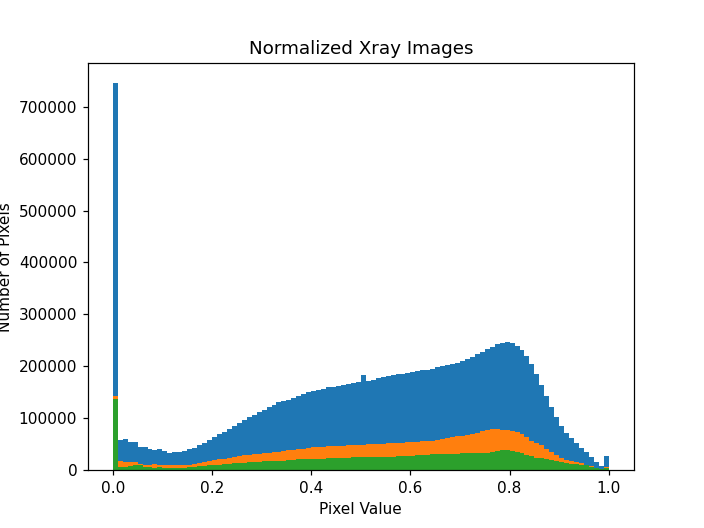

training (210, 256, 256, 1) {blue}
13115020
18039
validation (60, 256, 256, 1) {orange}
3822672
3563
testing (31, 256, 256, 1) {green}
1908191
2328


<IPython.core.display.Javascript object>


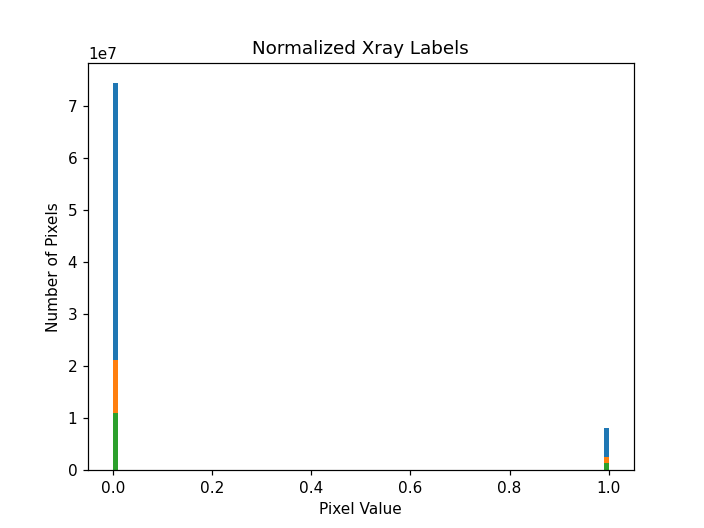

training (210, 256, 256, 6) {blue}
8142597
8142597
validation (60, 256, 256, 6) {orange}
2505241
2505241
testing (31, 256, 256, 6) {green}
1311524
1311524


In [3]:
INPUT2 = 'PreProcessed_Marked_images.hdf5' #changed from 'PreProcessed_Marked_images4.hdf5'
inh5 = h5py.File(INPUT2,'r')

train_images = inh5['training_images']
train_labels = inh5['training_labels']

validation_images = inh5['validation_images']
validation_labels = inh5['validation_labels']

test_images = inh5['testing_images']
test_labels = inh5['testing_labels']

# Checking that images were normalized to 0 - 1 pixels
plt.figure()
plt.title('Normalized Xray Images')
plt.ylabel('Number of Pixels')
plt.xlabel('Pixel Value')
print('training',train_images.shape, '{blue}')
pixels = np.ravel(train_images)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))
#plt.figure()
print('validation',validation_images.shape, '{orange}')
pixels = np.ravel(validation_images)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))
#plt.figure()
print('testing',test_images.shape, '{green}')
pixels = np.ravel(test_images)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))

# Checking that labels were normalized to either 0 or 1 pixel
plt.figure()
plt.title('Normalized Xray Labels')
plt.ylabel('Number of Pixels')
plt.xlabel('Pixel Value')
print('training',train_labels.shape, '{blue}')
pixels = np.ravel(train_labels)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))
#plt.figure()
print('validation',validation_labels.shape, '{orange}')
pixels = np.ravel(validation_labels)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))
#plt.figure()
print('testing',test_labels.shape, '{green}')
pixels = np.ravel(test_labels)
plt.hist(pixels, bins = 100)
print(np.count_nonzero(pixels))
print(np.count_nonzero(pixels == 1))

<IPython.core.display.Javascript object>


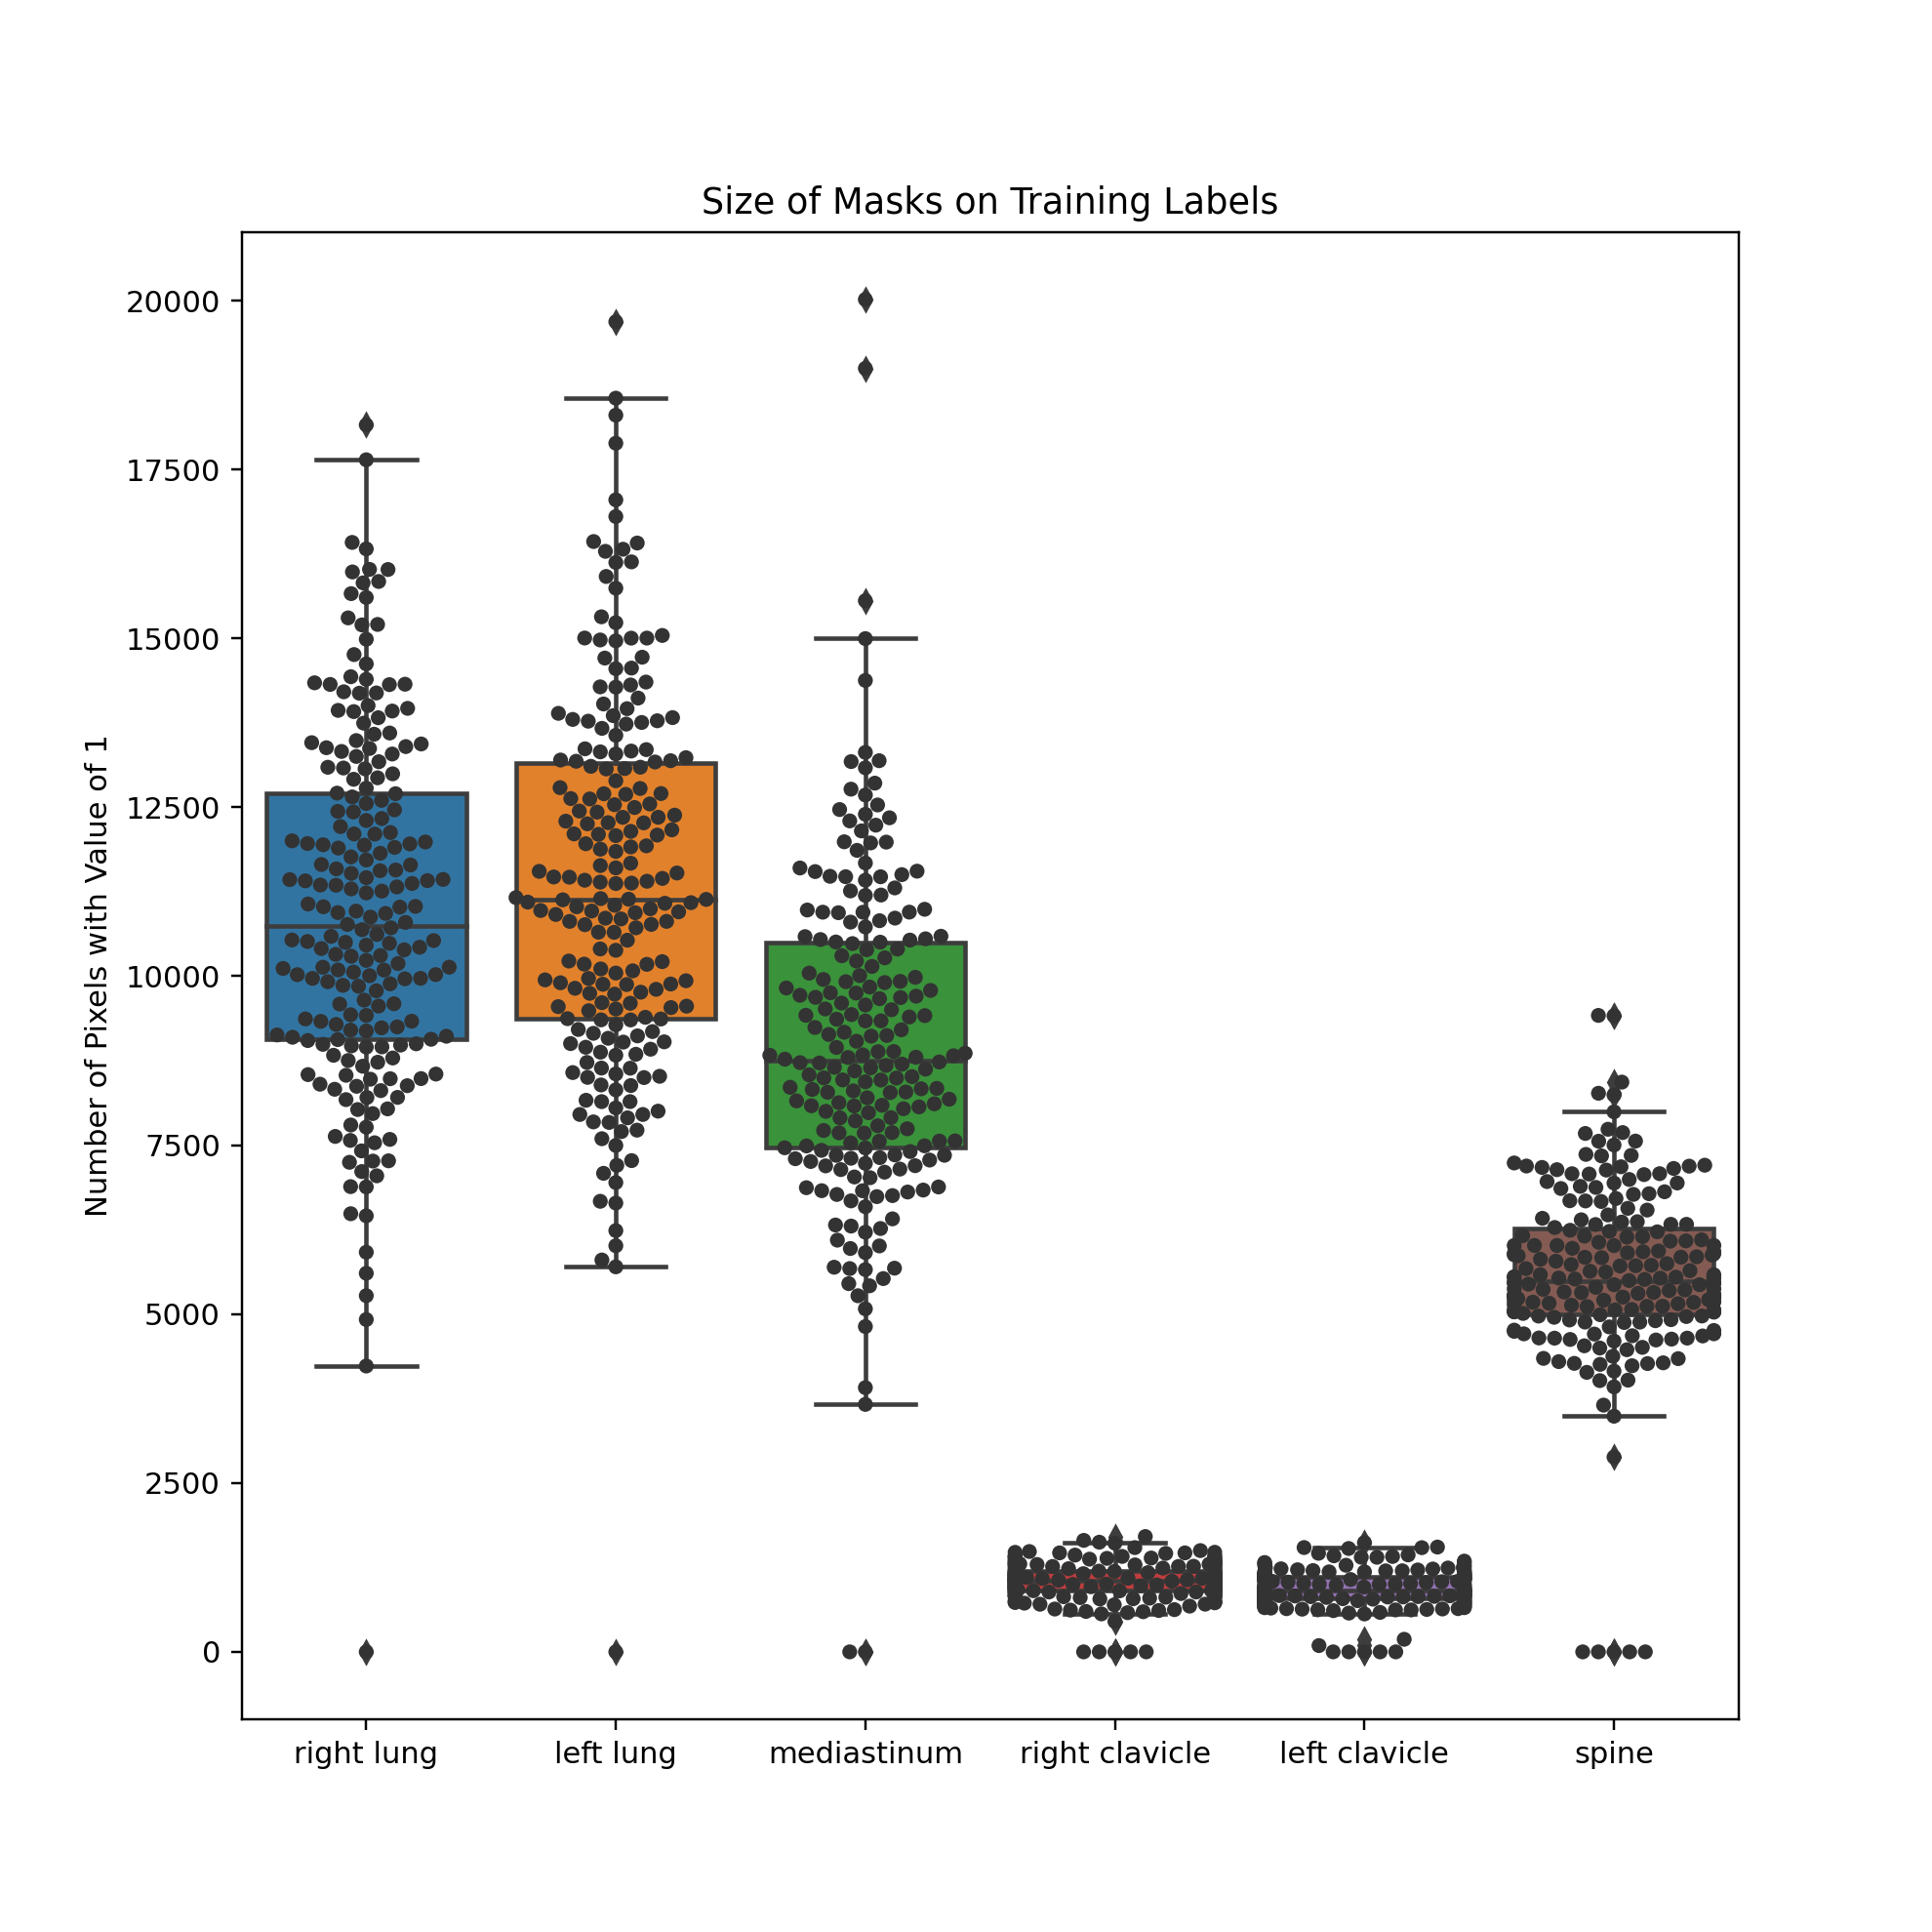

right lung , check outlier images index: (array([53, 58]),)
left lung , check outlier images index: (array([ 53, 169]),)
mediastinum , check outlier images index: (array([ 53, 156, 158, 169, 199]),)
right clavicle , check outlier images index: (array([  0,   4,  53, 126, 177, 183, 193, 199]),)
left clavicle , check outlier images index: (array([  4,  53, 126, 177, 180, 183, 199, 208]),)
spine , check outlier images index: (array([  0,  53,  60,  65,  66,  87,  95, 126, 146, 199, 202]),)


In [15]:
# Training Label Distribution
results = np.zeros((train_labels.shape[0], train_labels.shape[-1]))
for i in range(len(train_labels)):
    for ch in range(train_labels.shape[-1]):
        results[i,ch] = np.count_nonzero(np.ravel(train_labels[i,...,ch]))

# Let's make a swarm plot 
fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(1,1,1)
ax1 = sns.boxplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]])
ax1 = sns.swarmplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]], color=".2")
plt.title('Size of Masks on Training Labels')
plt.xticks([0,1,2,3,4,5], ('right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine'))
ax1.set_ylabel('Number of Pixels with Value of 1')

# Printing Index of Outlier Images in Training
Q1 = np.zeros(results.shape[-1])
Q3 = np.zeros(results.shape[-1])
IQR = np.zeros(results.shape[-1])
anatomy = ['right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine']
for ch in range(results.shape[-1]):
    Q1[ch] = np.quantile(results[:,ch], 0.25)
    Q3[ch] = np.quantile(results[:,ch], 0.75)
    IQR[ch] = Q3[ch] - Q1[ch]
    print( anatomy[ch] ,
      '\n\t outlier Image: ',
      np.where((results[:,...,ch] < (Q1[ch] - 1.5 * IQR[ch])) | (results[:,...,ch] > (Q3[ch] + 1.5 * IQR[ch]))))

<IPython.core.display.Javascript object>


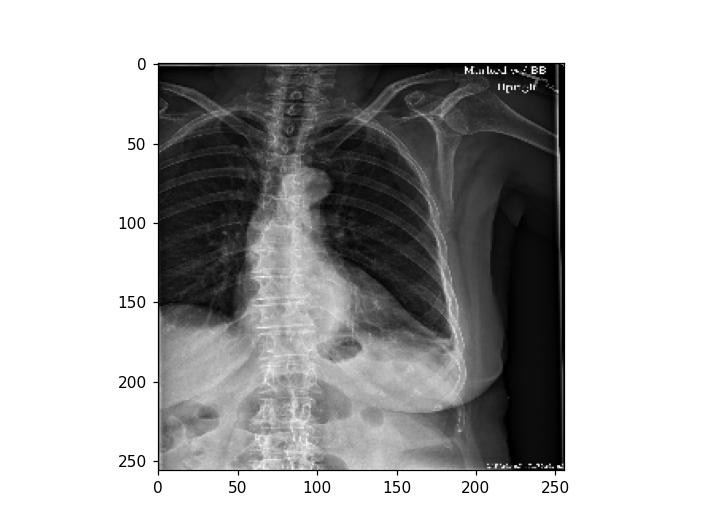

<IPython.core.display.Javascript object>


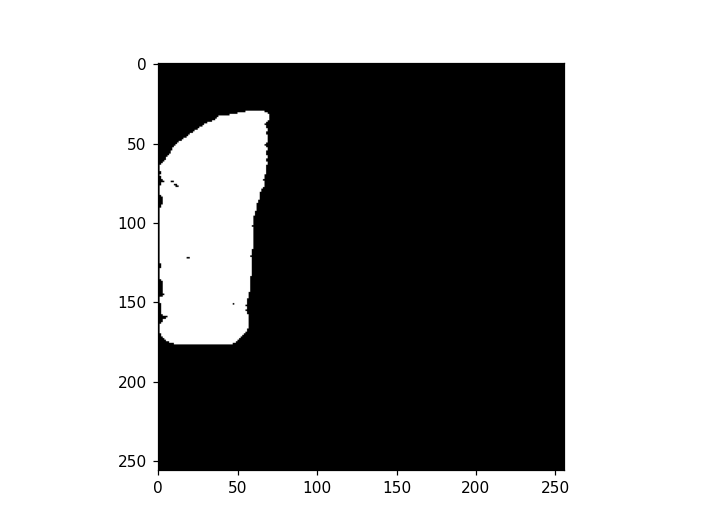

<IPython.core.display.Javascript object>


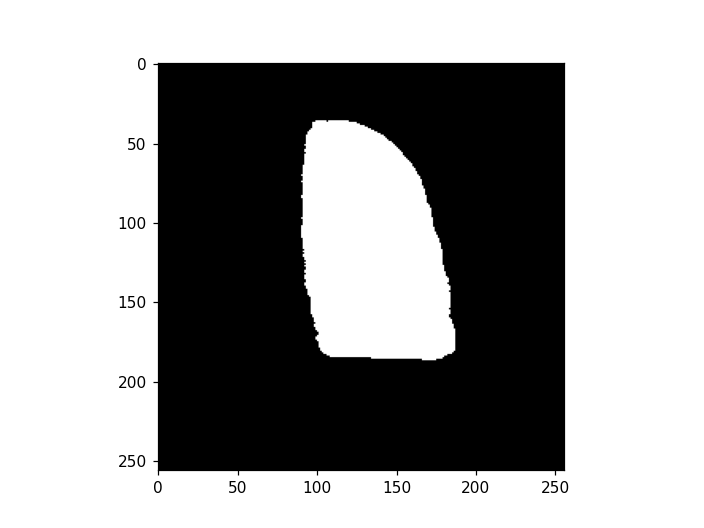

<IPython.core.display.Javascript object>


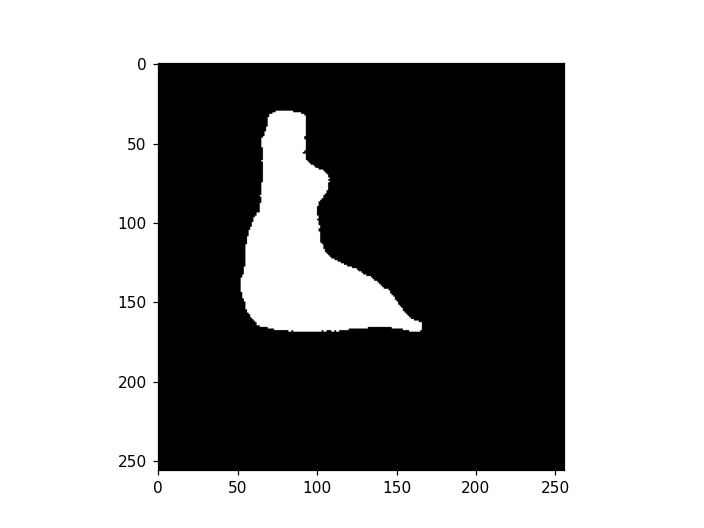

<IPython.core.display.Javascript object>


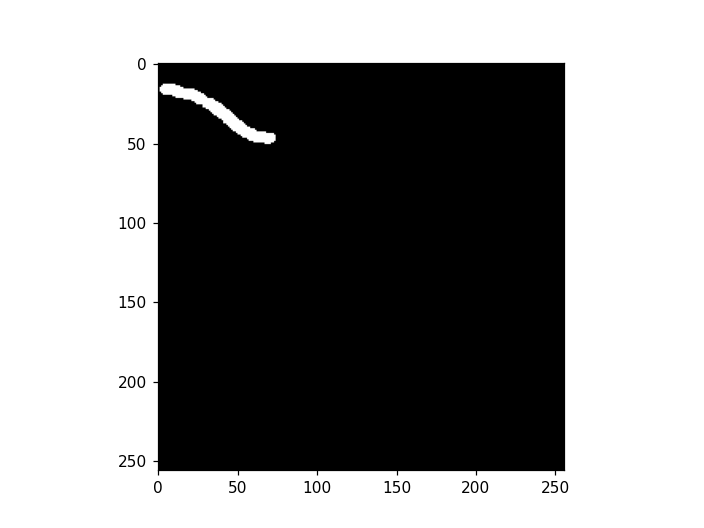

<IPython.core.display.Javascript object>


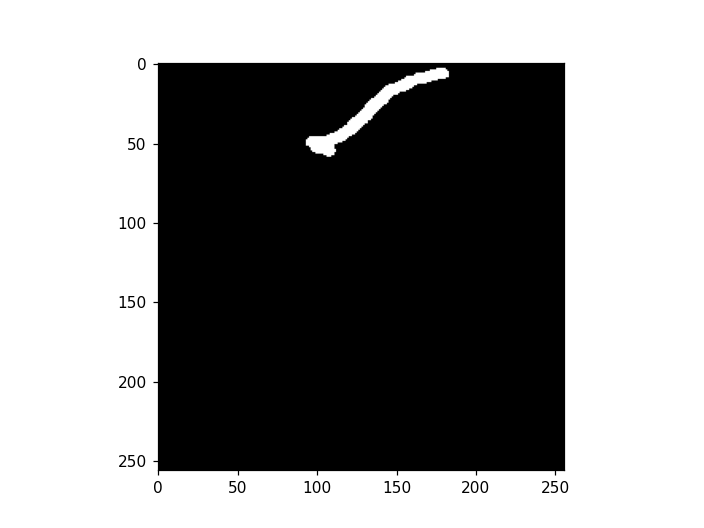

<IPython.core.display.Javascript object>


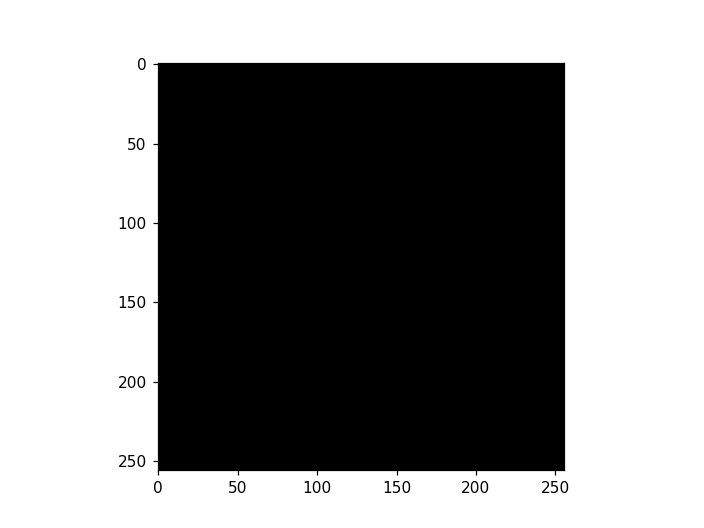

<IPython.core.display.Javascript object>


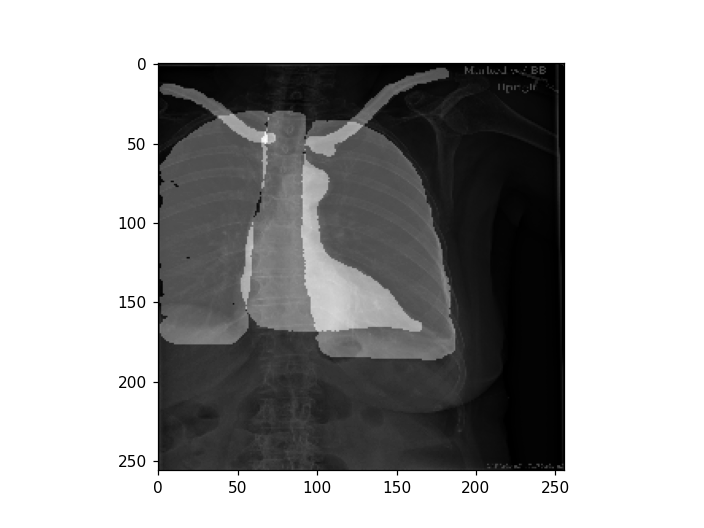

In [29]:
# Checking the outliers
trainix = 202
plt.figure()
plt.imshow(train_images[trainix,:,:,0],cmap='gray')
plt.figure()
plt.imshow(train_labels[trainix,:,:,0],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_labels[trainix,:,:,1],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_labels[trainix,:,:,2],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_labels[trainix,:,:,3],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_labels[trainix,:,:,4],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_labels[trainix,:,:,5],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(train_images[trainix,:,:,0] + train_labels[trainix,:,:,0] + train_labels[trainix,:,:,1] + train_labels[trainix,:,:,2] + train_labels[trainix,:,:,3] + train_labels[trainix,:,:,4] + train_labels[trainix,:,:,5], cmap='gray')

<IPython.core.display.Javascript object>


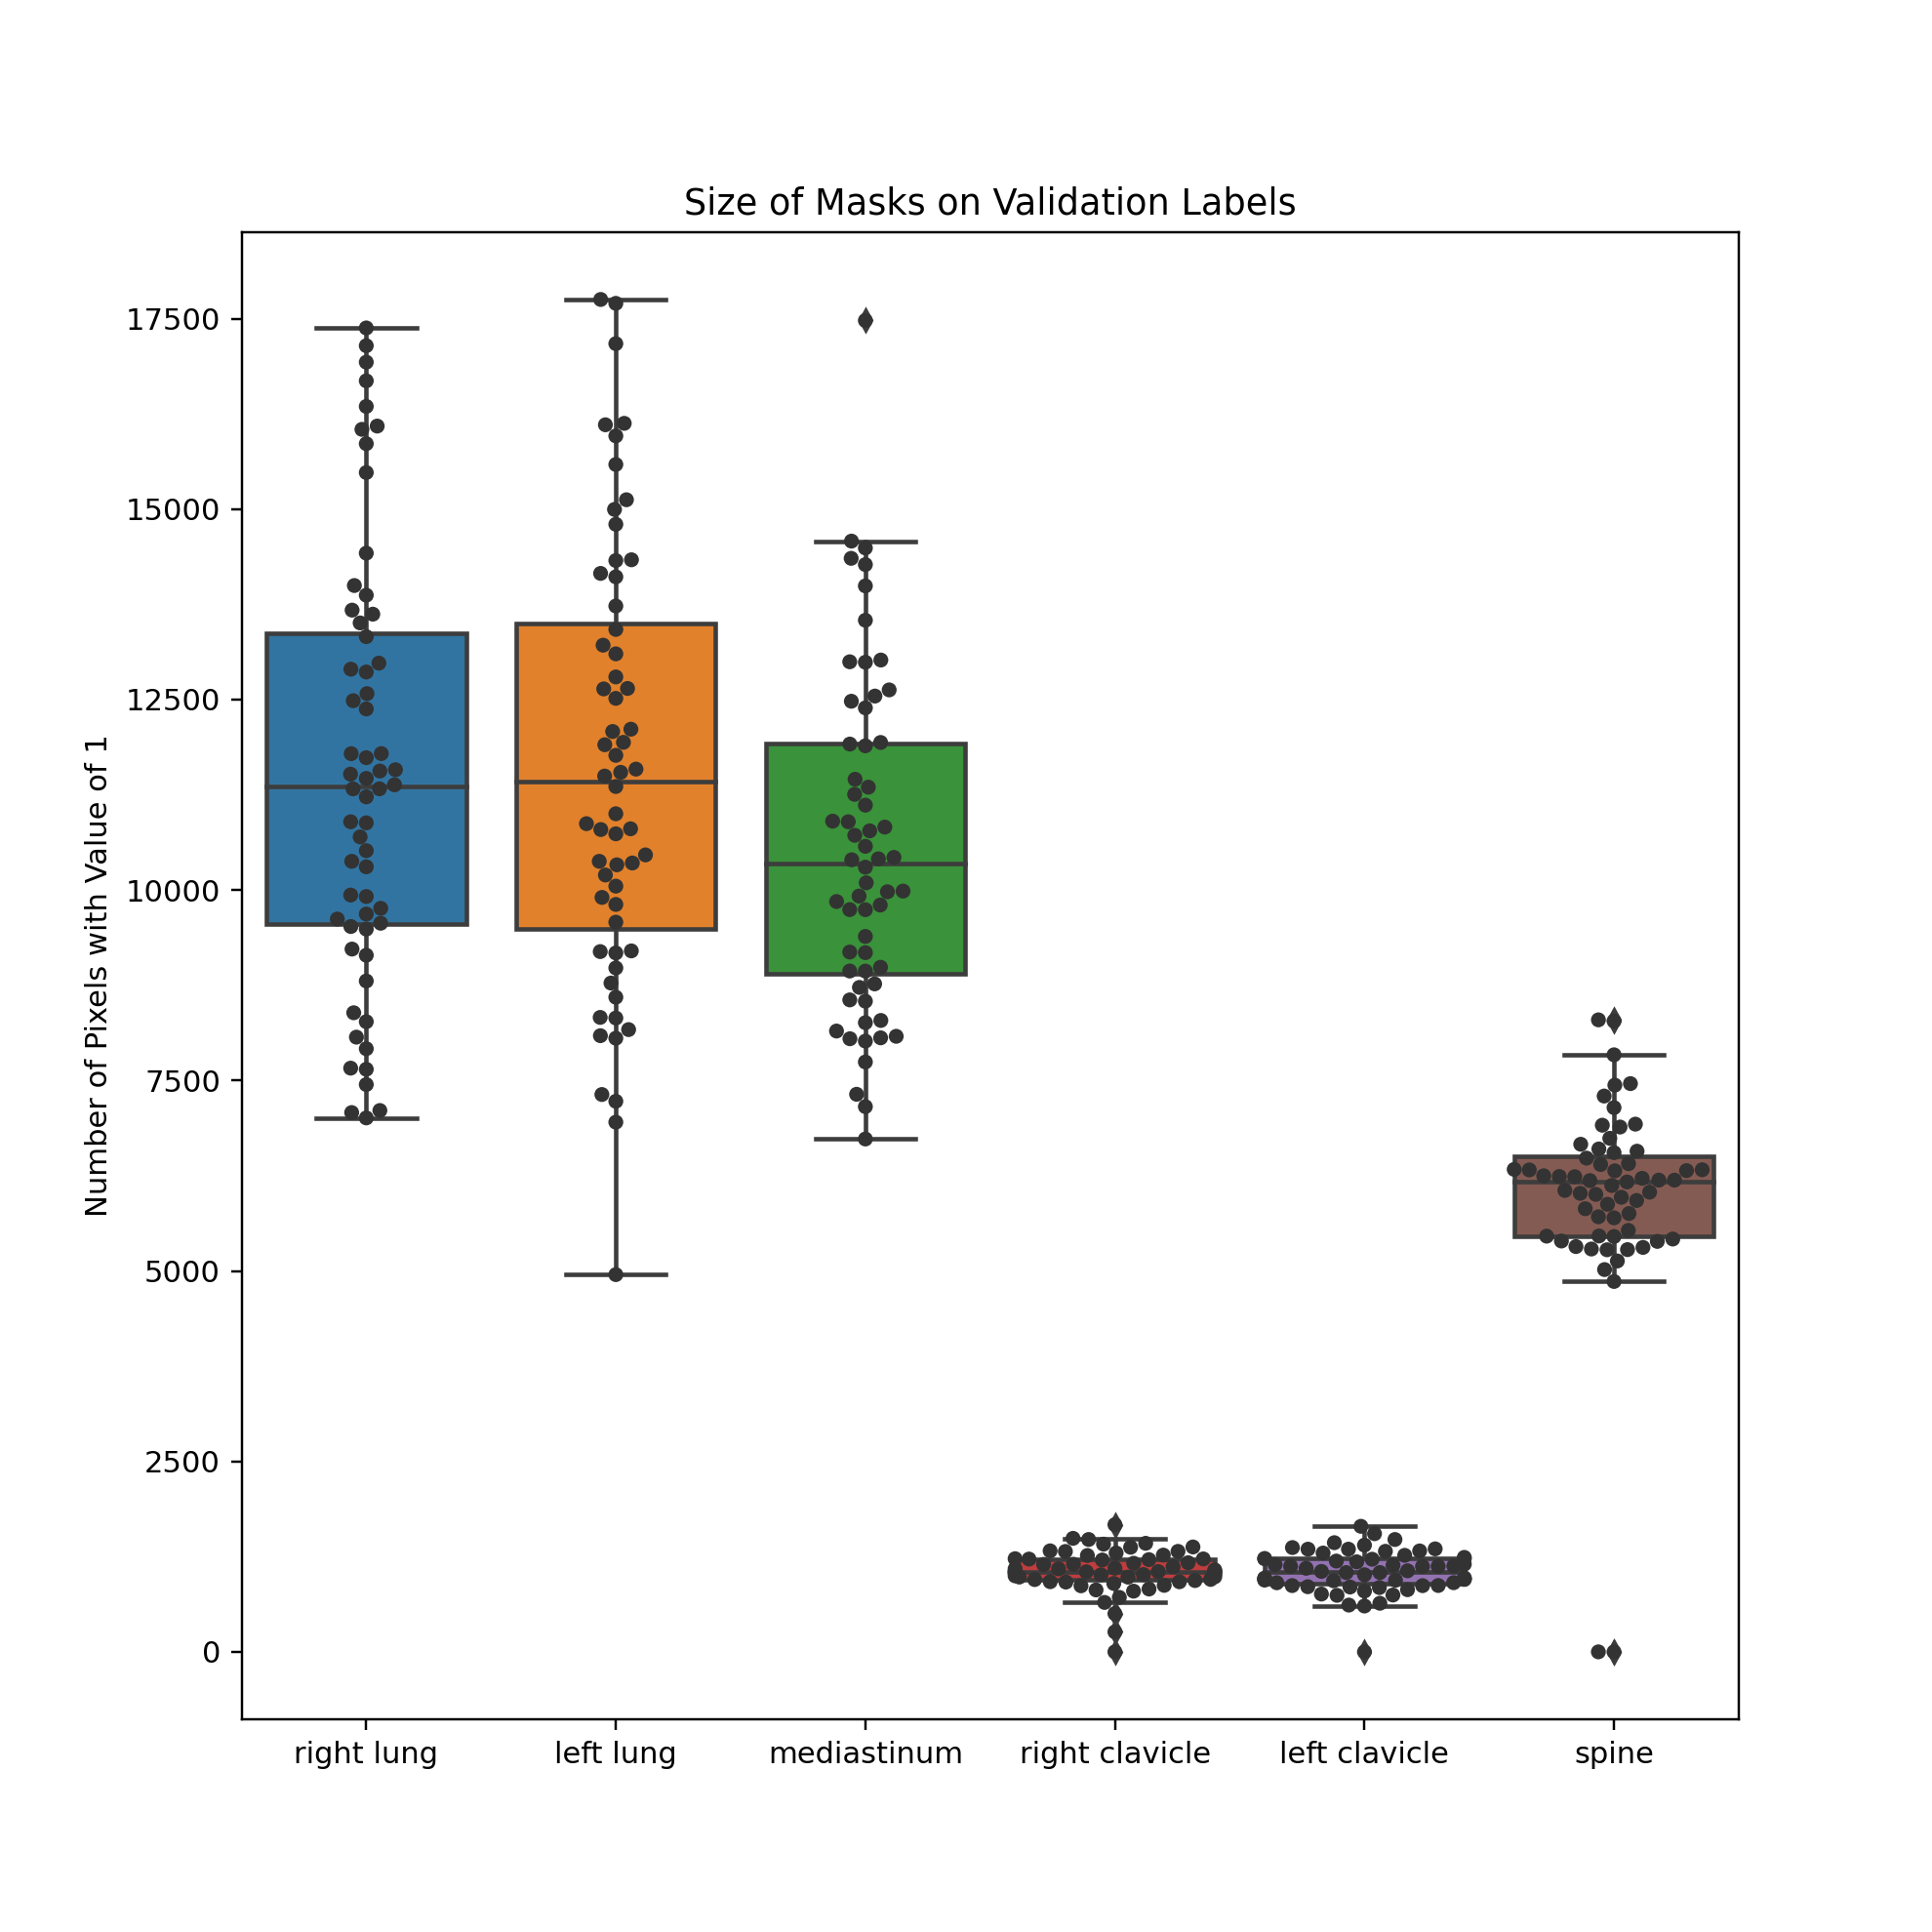

right lung , check outlier images index: (array([], dtype=int64),)
left lung , check outlier images index: (array([], dtype=int64),)
mediastinum , check outlier images index: (array([19]),)
right clavicle , check outlier images index: (array([12, 18, 22, 29]),)
left clavicle , check outlier images index: (array([29]),)
spine , check outlier images index: (array([15, 22, 47, 51]),)


In [16]:
# Validation Label Distribution
results = np.zeros((validation_labels.shape[0], validation_labels.shape[-1]))
for i in range(len(validation_labels)):
    for ch in range(validation_labels.shape[-1]):
        results[i,ch] = np.count_nonzero(np.ravel(validation_labels[i,...,ch]))

# Let's make a swarm plot 
fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(1,1,1)
ax1 = sns.boxplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]])
ax1 = sns.swarmplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]], color=".2")
plt.title('Size of Masks on Validation Labels')
plt.xticks([0,1,2,3,4,5], ('right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine'))
ax1.set_ylabel('Number of Pixels with Value of 1')

# Printing Index of Outlier Images in Validation
Q1 = np.zeros(results.shape[-1])
Q3 = np.zeros(results.shape[-1])
IQR = np.zeros(results.shape[-1])
anatomy = ['right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine']
for ch in range(results.shape[-1]):
    Q1[ch] = np.quantile(results[:,ch], 0.25)
    Q3[ch] = np.quantile(results[:,ch], 0.75)
    IQR[ch] = Q3[ch] - Q1[ch]
    print( anatomy[ch] ,
      '\n\t outlier Image: ',
      np.where((results[:,...,ch] < (Q1[ch] - 1.5 * IQR[ch])) | (results[:,...,ch] > (Q3[ch] + 1.5 * IQR[ch]))))


<IPython.core.display.Javascript object>


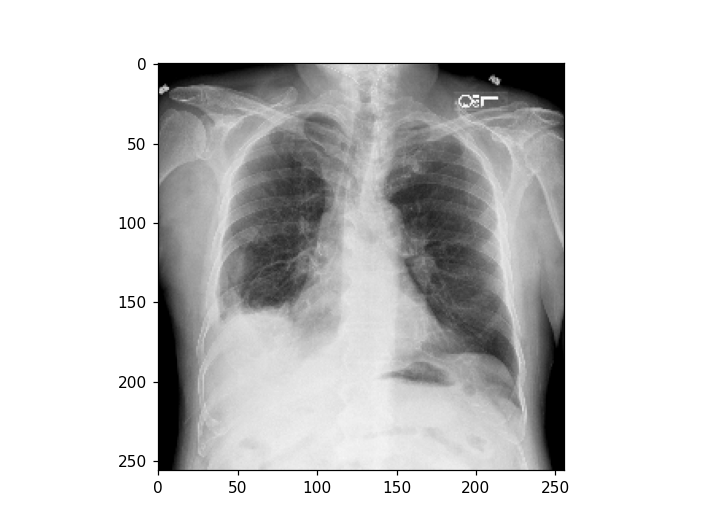

<IPython.core.display.Javascript object>


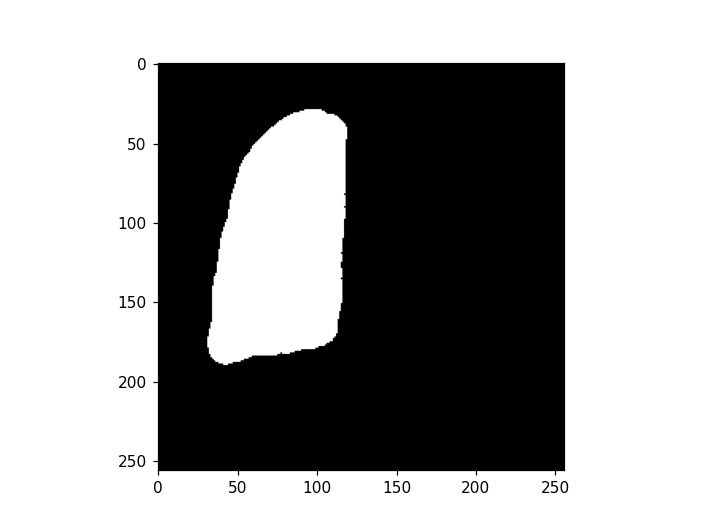

<IPython.core.display.Javascript object>


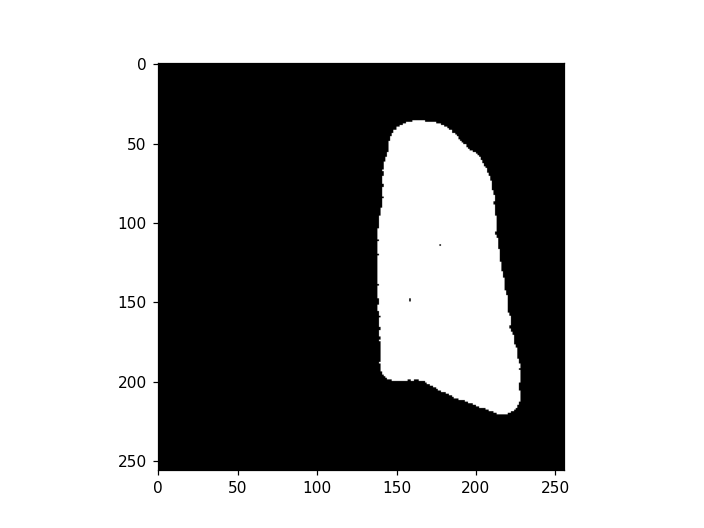

<IPython.core.display.Javascript object>


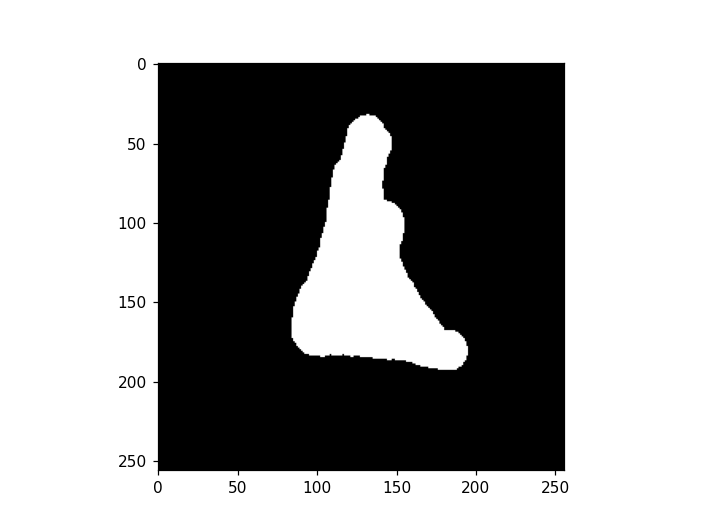

<IPython.core.display.Javascript object>


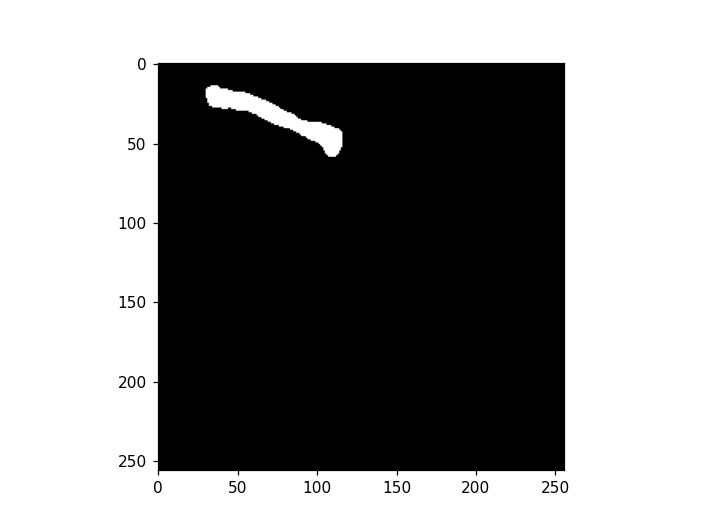

<IPython.core.display.Javascript object>


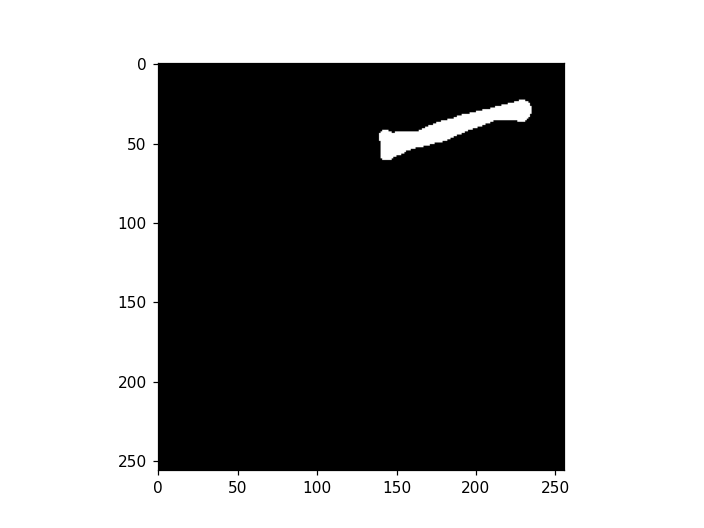

<IPython.core.display.Javascript object>


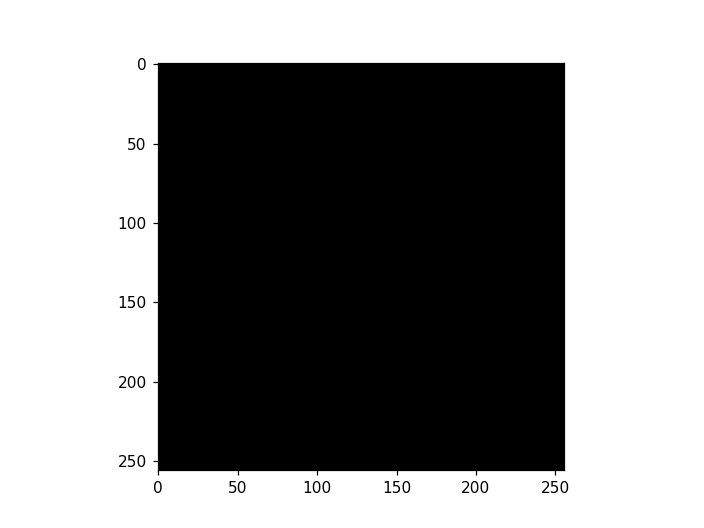

<IPython.core.display.Javascript object>


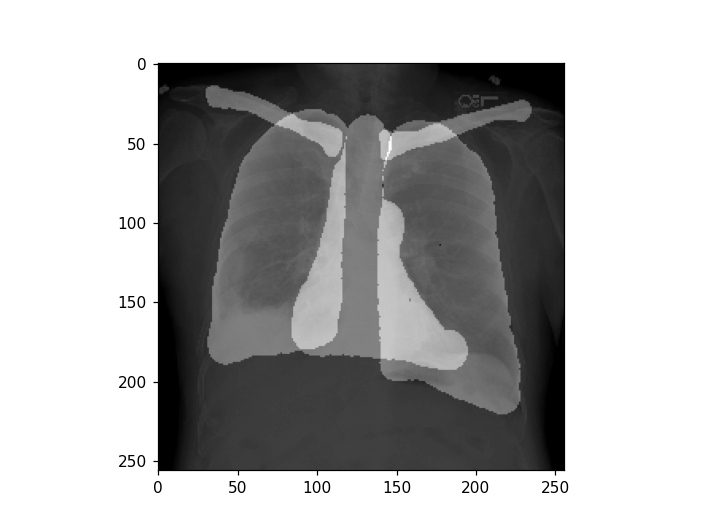

In [38]:
# Sample of Validation image w/ Masks
trainix = 51
plt.figure()
plt.imshow(validation_images[trainix,:,:,0],cmap='gray')
plt.figure()
plt.imshow(validation_labels[trainix,:,:,0],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_labels[trainix,:,:,1],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_labels[trainix,:,:,2],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_labels[trainix,:,:,3],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_labels[trainix,:,:,4],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_labels[trainix,:,:,5],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(validation_images[trainix,:,:,0] + validation_labels[trainix,:,:,0] + validation_labels[trainix,:,:,1] + validation_labels[trainix,:,:,2] + validation_labels[trainix,:,:,3] + validation_labels[trainix,:,:,4] + validation_labels[trainix,:,:,5], cmap='gray')

<IPython.core.display.Javascript object>


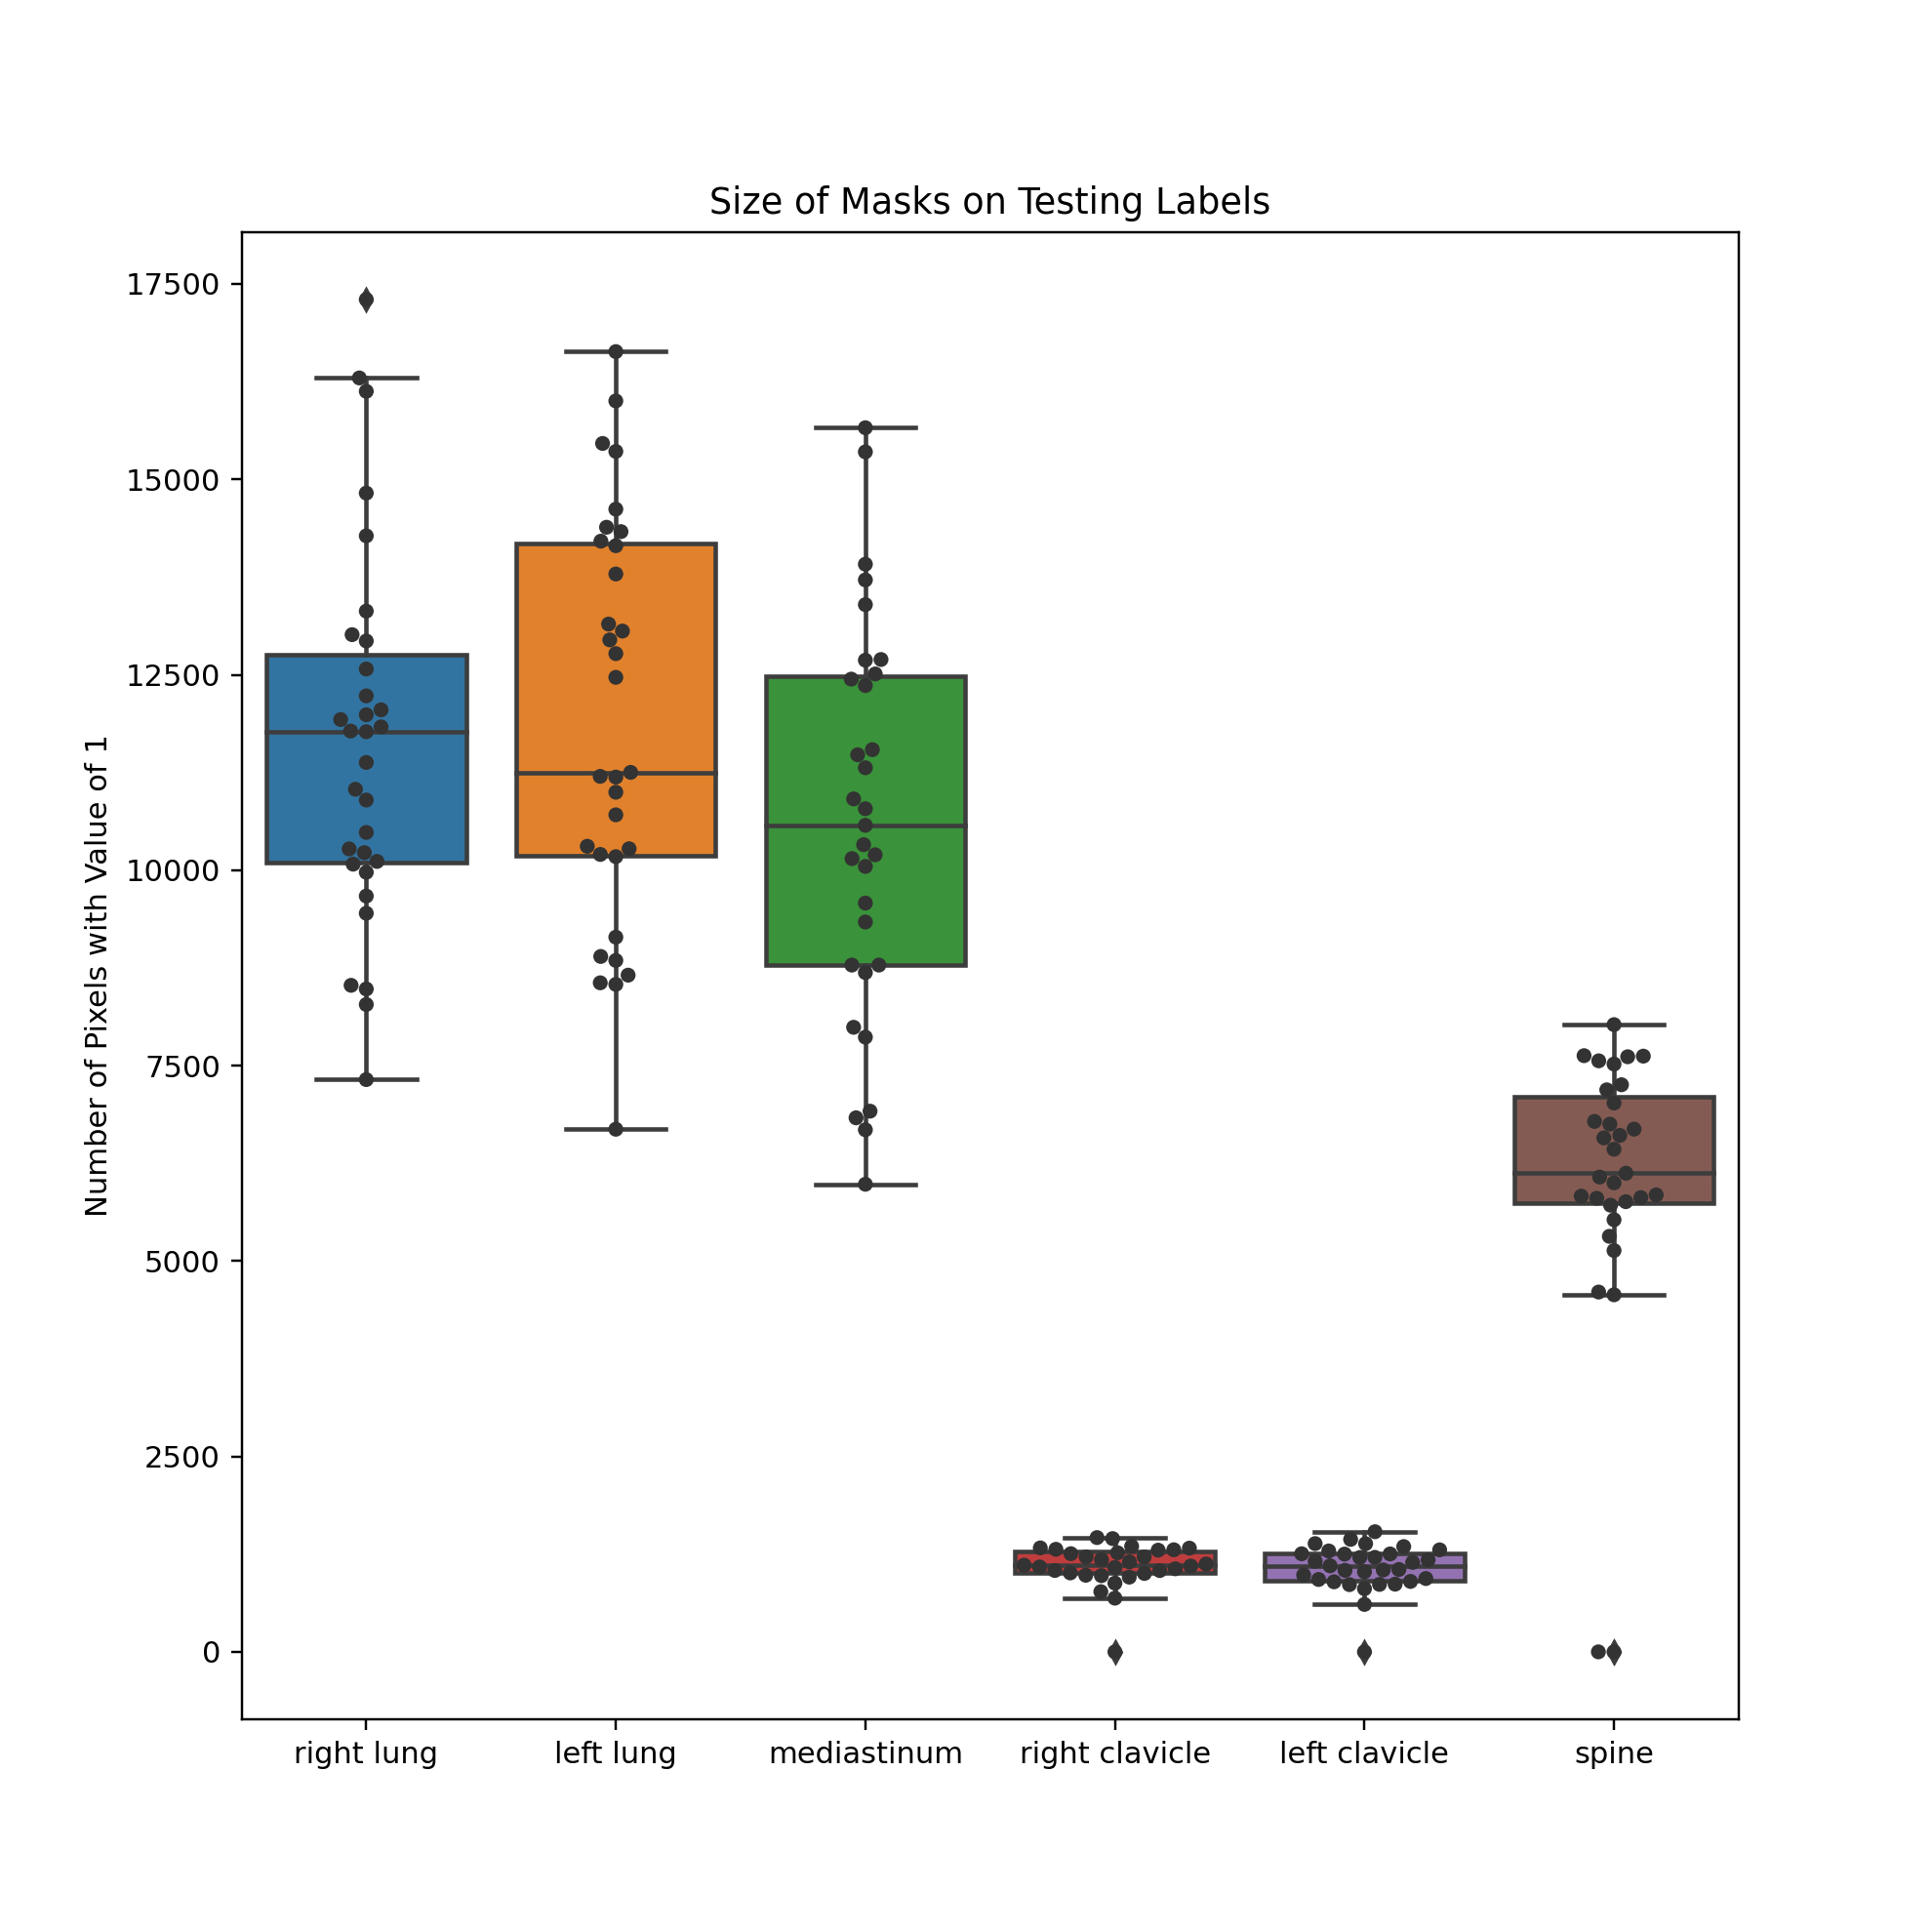

right lung , check outlier images index: (array([16]),)
left lung , check outlier images index: (array([], dtype=int64),)
mediastinum , check outlier images index: (array([], dtype=int64),)
right clavicle , check outlier images index: (array([16]),)
left clavicle , check outlier images index: (array([16]),)
spine , check outlier images index: (array([12, 14]),)


In [17]:
# Testing Label Distribution
results = np.zeros((test_labels.shape[0], test_labels.shape[-1]))
for i in range(len(test_labels)):
    for ch in range(test_labels.shape[-1]):
        results[i,ch] = np.count_nonzero(np.ravel(test_labels[i,...,ch]))

# Let's make a swarm plot 
fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(1,1,1)
ax1 = sns.boxplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]])
ax1 = sns.swarmplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]], color=".2")
plt.title('Size of Masks on Testing Labels')
plt.xticks([0,1,2,3,4,5], ('right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine'))
ax1.set_ylabel('Number of Pixels with Value of 1')

# Printing Index of Outlier Images in Testing
Q1 = np.zeros(results.shape[-1])
Q3 = np.zeros(results.shape[-1])
IQR = np.zeros(results.shape[-1])
anatomy = ['right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine']
for ch in range(results.shape[-1]):
    Q1[ch] = np.quantile(results[:,ch], 0.25)
    Q3[ch] = np.quantile(results[:,ch], 0.75)
    IQR[ch] = Q3[ch] - Q1[ch]
    print( anatomy[ch] ,
      '\n\t outlier Image: ',
      np.where((results[:,...,ch] < (Q1[ch] - 1.5 * IQR[ch])) | (results[:,...,ch] > (Q3[ch] + 1.5 * IQR[ch]))))


<IPython.core.display.Javascript object>


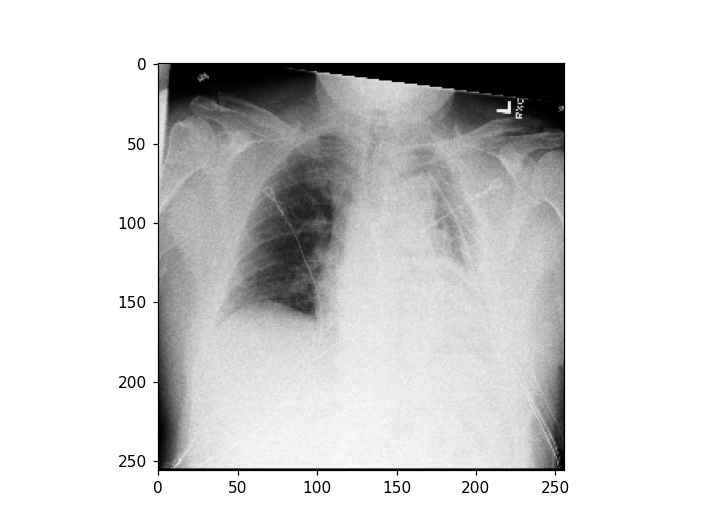

<IPython.core.display.Javascript object>


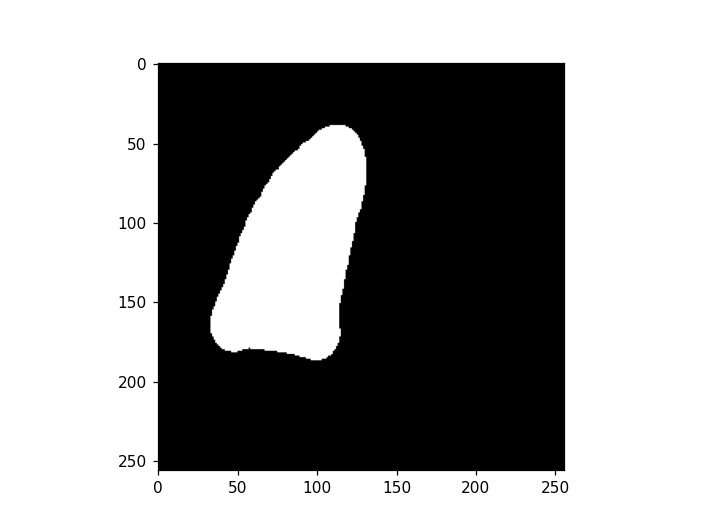

<IPython.core.display.Javascript object>


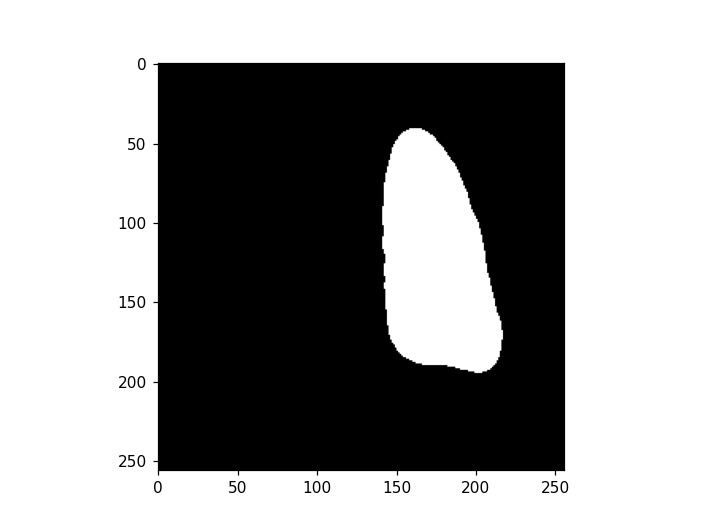

<IPython.core.display.Javascript object>


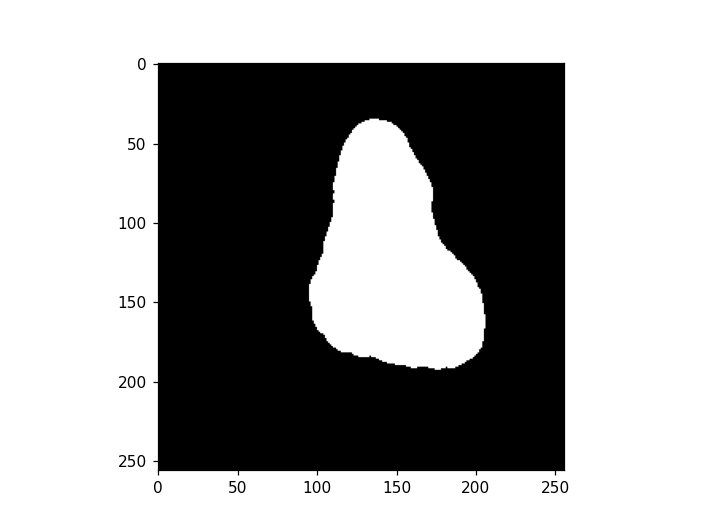

<IPython.core.display.Javascript object>


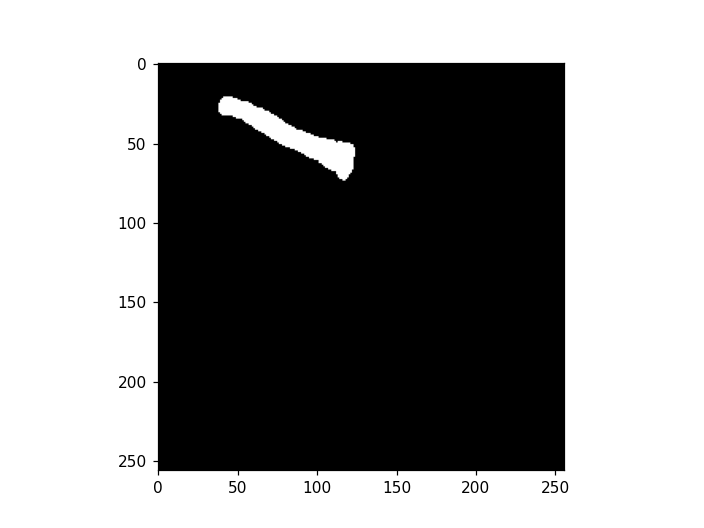

<IPython.core.display.Javascript object>


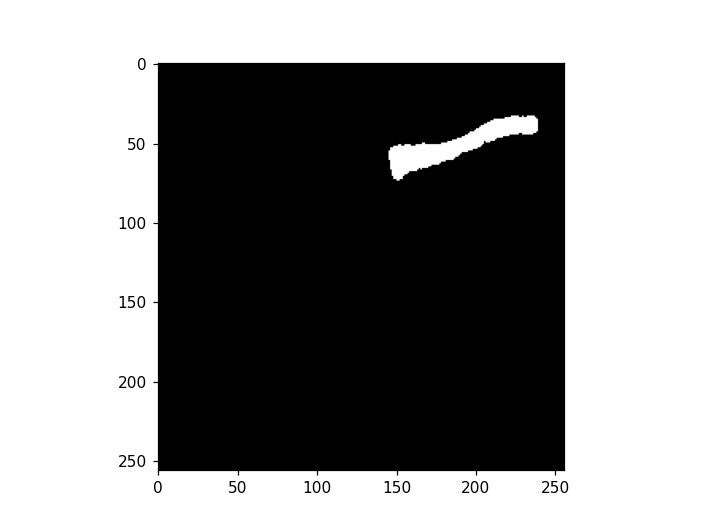

<IPython.core.display.Javascript object>


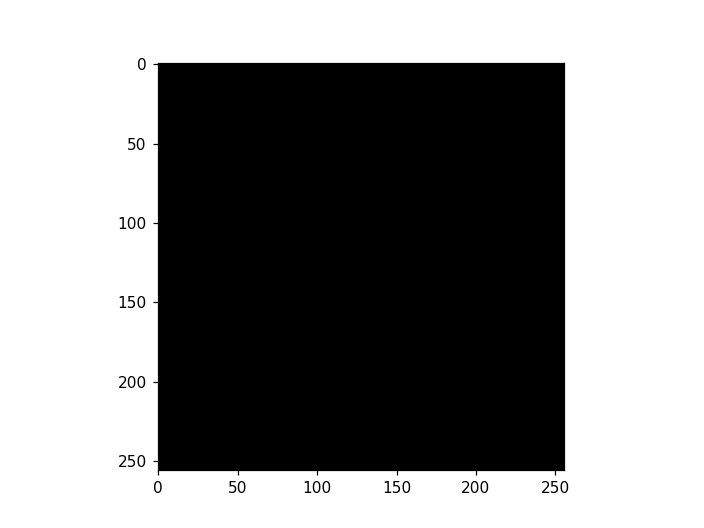

<IPython.core.display.Javascript object>


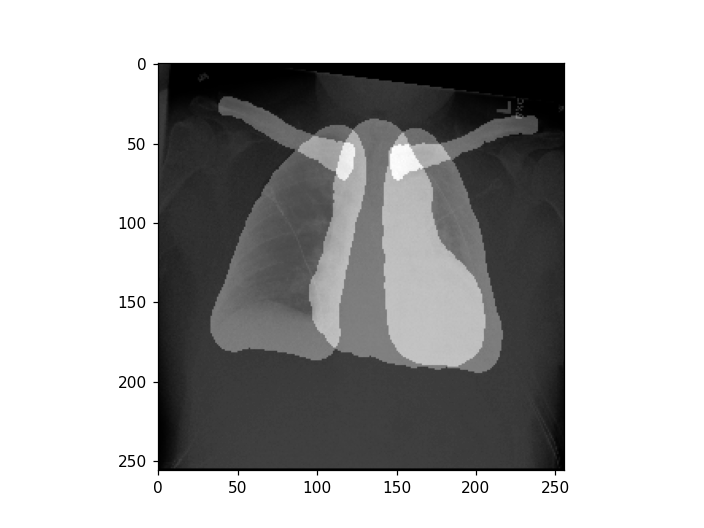

In [41]:
# Sample of Test image w/ Masks
trainix = 14
plt.figure()
plt.imshow(test_images[trainix,:,:,0],cmap='gray')
plt.figure()
plt.imshow(test_labels[trainix,:,:,0],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_labels[trainix,:,:,1],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_labels[trainix,:,:,2],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_labels[trainix,:,:,3],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_labels[trainix,:,:,4],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_labels[trainix,:,:,5],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(test_images[trainix,:,:,0] + test_labels[trainix,:,:,0] + test_labels[trainix,:,:,1] + test_labels[trainix,:,:,2] + test_labels[trainix,:,:,3] + test_labels[trainix,:,:,4] + test_labels[trainix,:,:,5], cmap='gray')

In [42]:
inh5.close()

### PreProcessed_Marked_images5.hdf5 did not produce a superior model to PreProcessed_Marked_images4.hdf5

In [43]:
# Remove data with missing labels from preprocessing
Input = 'PreProcessed_Marked_images.hdf5' #changed from 'PreProcessed_Marked_images4.hdf5'
Output = 'PreProcessed_Marked_images2.hdf5' #changed from 'PreProcessed_Marked_images5.hdf5'

try:
    os.remove(OUTPUT)
except:
    pass
inh5 = h5py.File(Input,'r')
outh5 = h5py.File(Output,'a')


In [44]:
try:
    outh5.create_dataset("training_images", (205, 256, 256, 1), dtype=np.float32) # rm 5 train imgs
    outh5.create_dataset("validation_images", (58, 256, 256, 1), dtype=np.float32) # rm 2 val imgs
    outh5.create_dataset("testing_images", (29, 256, 256, 1), dtype=np.float32) # rm 2 test imgs
    
    # dimension[4] has 6 values for 6 channels
    outh5.create_dataset("training_labels", (205, 256, 256, 6), dtype=np.float32)
    outh5.create_dataset("validation_labels", (58, 256, 256, 6), dtype=np.float32)
    outh5.create_dataset("testing_labels", (29, 256, 256, 6), dtype=np.float32)
except:
    traceback.print_exc()  

In [45]:
# Creating an indexing that excludes empty images in Training
N_list = list(range(210))
indexes = [53, 65, 126, 199, 202]
# delete in reverse order to not throw off the subsequent indexes.
for i in sorted(indexes, reverse=True):
    del N_list[i]

# create a randomizer to randomize the new training data
countlist = np.arange(0, 205)
np.random.shuffle(countlist) #randomize training data
print(205)
print(countlist)

205
[133  43   1  28 201 117  51  88   6 169 100 119  56 109  30 122   9 139
 186 151 129 106  63 116 141  62 160 156 120  49  13  65  71  96 172 181
 188  57  95  50  53 193 194 148  55 159  69 191  85 203 125 202 175 132
  31 146 136  26  10  82  14 195 137 171 101 145 158 104  64 164  16 128
 143  83  68 192  66   4  75 174  22  84 185 184  73 127 144 200  15  52
 150 170 126  11  80  93  25  27  54 178 108 123 197  89 135  21 147 103
   8 154 111  33 183  32  67 107  78 166 140 179  76  44  24  70 110  58
  47  97 180   5  40 153  98   3  92  12 115  77  23 198  45  39 176 161
 131  46 162 196 124  41 187  19 152 113  61  35 163 190  91 105  18 121
 114   2 177  34 199   0  74 112 168 165  42 118 102  38  79   7  17  81
  72 182  60  20 189 149  90  29 138  86  37 142  94  59 157  36 167 204
 173  99 155 134  87  48 130]


In [46]:
counter = 0
for i in range(205):
    inim = np.array(inh5['training_images'][N_list[i],...]).astype('float32')
    inl = np.array(inh5['training_labels'][N_list[i],...]).astype('float32')

    outh5['training_images'][countlist[counter], ...] = inim
    outh5['training_labels'][countlist[counter], ...] = inl
    
    counter += 1
    
    print(counter / 205 * 100)

0.4878048780487805
0.975609756097561
1.4634146341463417
1.951219512195122
2.4390243902439024
2.9268292682926833
3.414634146341464
3.902439024390244
4.390243902439024
4.878048780487805
5.365853658536586
5.853658536585367
6.341463414634147
6.829268292682928
7.317073170731707
7.804878048780488
8.292682926829269
8.780487804878048
9.268292682926829
9.75609756097561
10.24390243902439
10.731707317073171
11.219512195121952
11.707317073170733
12.195121951219512
12.682926829268293
13.170731707317074
13.658536585365855
14.146341463414632
14.634146341463413
15.121951219512194
15.609756097560975
16.097560975609756
16.585365853658537
17.073170731707318
17.560975609756095
18.048780487804876
18.536585365853657
19.024390243902438
19.51219512195122
20.0
20.48780487804878
20.975609756097562
21.463414634146343
21.951219512195124
22.439024390243905
22.926829268292686
23.414634146341466
23.902439024390244
24.390243902439025
24.878048780487806
25.365853658536587
25.853658536585368
26.34146341463415
26.829268

In [47]:
# Creating an indexing that excludes empty images in Validation
N_list = list(range(60))
indexes = [47, 51]
# delete in reverse order to not throw off the subsequent indexes.
for i in sorted(indexes, reverse=True):
    del N_list[i]

# do not randomize the new validation data
countlist = np.arange(0, 58)
print(58)
print(countlist)

58
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


In [48]:
counter = 0
for i in range(58):
    inim = np.array(inh5['validation_images'][N_list[i],...]).astype('float32')
    inl = np.array(inh5['validation_labels'][N_list[i],...]).astype('float32')

    outh5['validation_images'][countlist[counter], ...] = inim
    outh5['validation_labels'][countlist[counter], ...] = inl
    
    counter += 1
    
    print(counter / 58 * 100)

1.7241379310344827
3.4482758620689653
5.172413793103448
6.896551724137931
8.620689655172415
10.344827586206897
12.068965517241379
13.793103448275861
15.517241379310345
17.24137931034483
18.96551724137931
20.689655172413794
22.413793103448278
24.137931034482758
25.862068965517242
27.586206896551722
29.310344827586203
31.03448275862069
32.758620689655174
34.48275862068966
36.206896551724135
37.93103448275862
39.6551724137931
41.37931034482759
43.103448275862064
44.827586206896555
46.55172413793103
48.275862068965516
50.0
51.724137931034484
53.44827586206896
55.172413793103445
56.896551724137936
58.620689655172406
60.3448275862069
62.06896551724138
63.793103448275865
65.51724137931035
67.24137931034483
68.96551724137932
70.6896551724138
72.41379310344827
74.13793103448276
75.86206896551724
77.58620689655173
79.3103448275862
81.03448275862068
82.75862068965517
84.48275862068965
86.20689655172413
87.93103448275862
89.65517241379311
91.37931034482759
93.10344827586206
94.82758620689656
96.55

In [49]:
# Creating an indexing that excludes empty images in Validation
N_list = list(range(31))
indexes = [12, 14]
# delete in reverse order to not throw off the subsequent indexes.
for i in sorted(indexes, reverse=True):
    del N_list[i]

# do not randomize the new validation data
countlist = np.arange(0, 29)
print(29)
print(countlist)

29
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [50]:
counter = 0
for i in range(29):
    inim = np.array(inh5['testing_images'][N_list[i],...]).astype('float32')
    inl = np.array(inh5['testing_labels'][N_list[i],...]).astype('float32')

    outh5['testing_images'][countlist[counter], ...] = inim
    outh5['testing_labels'][countlist[counter], ...] = inl
    
    counter += 1
    
    print(counter / 29 * 100)

3.4482758620689653
6.896551724137931
10.344827586206897
13.793103448275861
17.24137931034483
20.689655172413794
24.137931034482758
27.586206896551722
31.03448275862069
34.48275862068966
37.93103448275862
41.37931034482759
44.827586206896555
48.275862068965516
51.724137931034484
55.172413793103445
58.620689655172406
62.06896551724138
65.51724137931035
68.96551724137932
72.41379310344827
75.86206896551724
79.3103448275862
82.75862068965517
86.20689655172413
89.65517241379311
93.10344827586206
96.55172413793103
100.0


In [51]:
inh5.close()
outh5.close()